In [1]:
from src.models.encoder_decoder import VQVAEEncoder
from src.models.vq import VectorQuantize
from src.preprocessing.preprocess_ucr import UCRDatasetImporter
from src.preprocessing.data_pipeline import build_data_pipeline
from src.utils import load_yaml_param_settings
from src.utils import (compute_downsample_rate,
                       get_root_dir,
                        time_to_timefreq,
                        timefreq_to_time,
                        quantize,
                        freeze)
import numpy as np
import torch

In [2]:
config_dir = 'src/configs/config.yaml' #dir to config file

config = load_yaml_param_settings(config_dir)

# data pipeline
dataset_importer = UCRDatasetImporter(**config['dataset'])
batch_size = config['dataset']['batch_sizes']['vqvae']
train_data_loader, test_data_loader = [build_data_pipeline(batch_size, dataset_importer, config, kind) for kind in ['train', 'test']]

y_train = train_data_loader.dataset.Y.flatten().astype(int)
y_test = test_data_loader.dataset.Y.flatten().astype(int)

self.X_train.shape: (500, 128)
self.X_test.shape: (625, 128)
# unique labels (train): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
# unique labels (test): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [3]:
import torch.nn.init as init
from torch import nn
def init_model(model):
    def weights_init(m):
        if hasattr(m, 'weight') and (isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)) or isinstance(m, nn.Linear)):
            init.kaiming_normal_(m.weight)
            if m.bias is not None:
                init.constant_(m.bias, 0)

    model.apply(weights_init)

    for module in model.modules():
        if isinstance(module, nn.BatchNorm2d):
            init.constant_(module.weight, 1)
            init.constant_(module.bias, 0)
            init.constant_(module.running_mean, 0)
            init.constant_(module.running_var, 1)
    
    return model

In [30]:
def to_zqs(dataloader):
    input_length = dataloader.dataset.X.shape[-1]

    n_fft = config['VQVAE']['n_fft']
    n_train_samples = len(dataloader.dataset)
    T_max = config['trainer_params']['max_epochs']['vqvae'] * (np.ceil(n_train_samples / config['dataset']['batch_sizes']['vqvae']) + 1)
    dim = config['encoder']['dim']
    in_channels = config['dataset']['in_channels']

    downsampled_width = config['encoder']['downsampled_width']
    downsampled_rate = compute_downsample_rate(input_length, n_fft, downsampled_width)
    
    
    encoder = init_model(VQVAEEncoder(dim, 2*in_channels, downsampled_rate, config['encoder']['n_resnet_blocks']))

    vqmodel = VectorQuantize(dim, config['VQVAE']['codebook']['size'], **config['VQVAE'])

    def encode_to_z_q(x):
        """
        x: (B, C, L)
        """
        C = x.shape[1]
        xf = time_to_timefreq(x, n_fft, C)  # (B, C, H, W)
        
        z = encoder(xf)  # (b c h w)
        z_q, indices, vq_loss, perplexity = quantize(z, vqmodel)  # (b c h w), (b (h w) h), ...
        return z_q, indices

    dataloader_iterator = iter(dataloader)
    number_of_batches = len(dataloader)
    
    zqs_list = []
    s_list = []

    for i in range(number_of_batches):
        try:
            x, y = next(dataloader_iterator)
        except StopIteration:
            dataloader_iterator = iter(dataloader)
            x, y = next(dataloader_iterator)
        
        z_q, s = encode_to_z_q(x)
        print(z_q.shape)
        for i, zq_i in enumerate(z_q):    
            zqs_list.append(zq_i.detach().tolist())
            s_list.append(s[i].tolist())

    zqs_tensor = torch.tensor(zqs_list, dtype=torch.float64)
    s_tensor = torch.tensor(s_list, dtype=torch.int32)
    return zqs_tensor, s_tensor

torch.Size([128, 64, 5, 8])
torch.Size([128, 64, 5, 8])
torch.Size([128, 64, 5, 8])
torch.Size([116, 64, 5, 8])
torch.Size([128, 64, 5, 8])
torch.Size([128, 64, 5, 8])
torch.Size([128, 64, 5, 8])
torch.Size([128, 64, 5, 8])
torch.Size([113, 64, 5, 8])


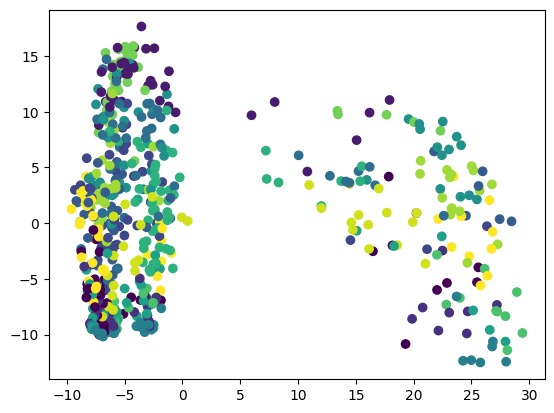

0.3244444444444444


In [31]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

zqs_tr, s_tr = to_zqs(train_data_loader)
zqs_ts, s_ts = to_zqs(test_data_loader)
Z = np.concatenate((torch.flatten(zqs_tr, start_dim=1), torch.flatten(zqs_ts, start_dim=1)), axis=0)
y = np.concatenate((y_train, y_test))

pca = PCA(n_components=2)
embs = pca.fit_transform(torch.flatten(zqs_ts, start_dim=1))

f, a = plt.subplots()
a.scatter(embs[:, 0], embs[:, 1], c=y_test)
plt.show()

Ztr, Zts, ytr, yts = train_test_split(Z, y, test_size=0.2)
svm = SVC(kernel='linear')
svm.fit(Ztr, ytr)
pr = svm.predict(Zts)
print(accuracy_score(yts, pr))